In [2]:
import pandas as pd
import wikipedia

In [6]:
def filter_olympic_2020_titles(titles):
    """
    Get the titles which are related to Olympic games hosted in 2020, given a list of titles
    """
    titles = [title for title in titles if '2020' in title and 'olympi' in title.lower()]
    
    return titles

def get_wiki_page(title):
    """
    Get the wikipedia page given a title
    """
    try:
        return wikipedia.page(title)
    except wikipedia.exceptions.DisambiguationError as e:
        return wikipedia.page(e.options[0])
    except wikipedia.exceptions.PageError as e:
        return None

def recursively_find_all_pages(titles, titles_so_far=set()):
    """
    Recursively find all the pages that are linked to the Wikipedia titles in the list
    """
    all_pages = []
    titles = list(set(titles) - titles_so_far)
    titles = filter_olympic_2020_titles(titles)
    titles_so_far.update(titles)
    print("recursively_find_pages")
    for title in titles:
        page = get_wiki_page(title)
        if page is None:
            continue
        all_pages.append(page)

        new_pages = recursively_find_all_pages(page.links, titles_so_far)
        for pg in new_pages:
            if pg.title not in [p.title for p in all_pages]:
                all_pages.append(pg)
        titles_so_far.update(page.links)
    return all_pages

pages = recursively_find_all_pages(["2020 Summer Olympics"])
len(pages)

recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively

recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively

recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively_find_pages
recursively

906

In [11]:
import re
from typing import Set
from transformers import GPT2TokenizerFast

import numpy as np
from nltk.tokenize import sent_tokenize

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    """count the number of tokens in a string"""
    return len(tokenizer.encode(text))

def reduce_long(
    long_text: str, long_text_tokens: bool = False, max_len: int = 590
) -> str:
    """
    Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i]) + "."

    return long_text

discard_categories = ['See also', 'References', 'External links', 'Further reading', "Footnotes",
    "Bibliography", "Sources", "Citations", "Literature", "Footnotes", "Notes and references",
    "Photo gallery", "Works cited", "Photos", "Gallery", "Notes", "References and sources",
    "References and notes",]


def extract_sections(
    wiki_text: str,
    title: str,
    max_len: int = 1500,
    discard_categories: Set[str] = discard_categories,
) -> str:
    """
    Extract the sections of a Wikipedia page, discarding the references and other low information sections
    """
    if len(wiki_text) == 0:
        return []

    # find all headings and the coresponding contents
    headings = re.findall("==+ .* ==+", wiki_text)
    for heading in headings:
        wiki_text = wiki_text.replace(heading, "==+ !! ==+")
    contents = wiki_text.split("==+ !! ==+")
    contents = [c.strip() for c in contents]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]
    
    # discard the discard categories, accounting for a tree structure
    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = " ".join(heading.split(" ")[1:-1])
        num_equals = len(heading.split(" ")[0])
        if num_equals <= keep_group_level:
            keep_group_level = max_level

        if num_equals > remove_group_level:
            if (
                num_equals <= keep_group_level
            ):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace("=", "").strip())
        ncontents.append(content)
        remove_group_level = max_level

    # count the tokens of each section
    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]

    # Create a tuple of (title, section_name, content, number of tokens)
    outputs += [(title, h, c, t) if t<max_len 
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len))) 
                    for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]
    
    return outputs

In [14]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shuang.peng/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [15]:
res = []
for page in pages:
    res += extract_sections(page.content, page.title)
df = pd.DataFrame(res, columns=["title", "heading", "content", "tokens"])
df = df[df.tokens>40]
df = df.drop_duplicates(['title','heading'])
df = df.reset_index().drop('index',axis=1) # reset index
df.head()

,title,heading,content,tokens
0,2020 Summer Olympics,Summary,The 2020 Summer Olympics (Japanese: 2020年夏季オリン...,716
1,2020 Summer Olympics,Host city selection,The International Olympic Committee (IOC) vote...,126
2,2020 Summer Olympics,Impact of the COVID-19 pandemic,"In January 2020, concerns were raised about th...",375
3,2020 Summer Olympics,Qualifying event cancellation and postponement,Concerns about the pandemic began to affect qu...,298
4,2020 Summer Olympics,Effect on doping tests,Mandatory doping tests were being severely res...,163


In [16]:
df.to_csv('olympics_sections.csv', index=False)

In [17]:
df.title.value_counts().head()

Concerns and controversies at the 2020 Summer Olympics    52
Great Britain at the 2020 Summer Olympics                 43
United States at the 2020 Summer Olympics                 43
Australia at the 2020 Summer Olympics                     39
Canada at the 2020 Summer Olympics                        39
Name: title, dtype: int64

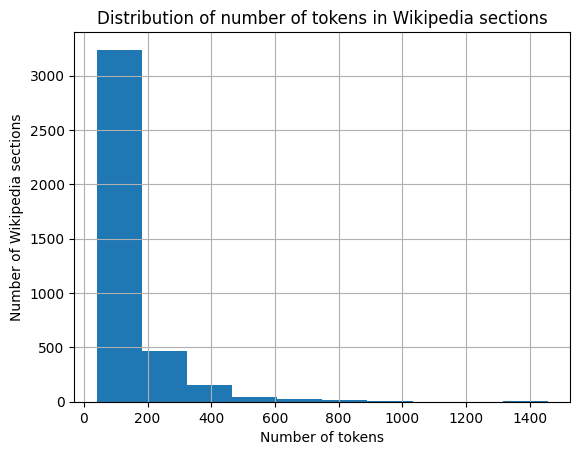

In [18]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('olympics_sections.csv')
df[['tokens']].hist()
# add axis descriptions and title
plt.xlabel('Number of tokens')
plt.ylabel('Number of Wikipedia sections')
plt.title('Distribution of number of tokens in Wikipedia sections')
plt.show()